In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-05 17:57:40.644064: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-05 17:57:53.993211: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-05 17:57:54.046361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-05 17:57:54.046403: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-05 17:57:54.048796: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-05 17:57:54.051082: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps) 
    
pre_data = data[..., -4:-3]
post_data = data[..., -1:]
t_star = t_star[-3:-1]
data = data[..., -3:-1]
T = t_star.shape[0]    
    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size


In [6]:
pre_data.shape

(2, 100, 100, 1)

In [7]:
post_data.shape

(2, 100, 100, 1)

In [8]:
data.shape

(2, 100, 100, 2)

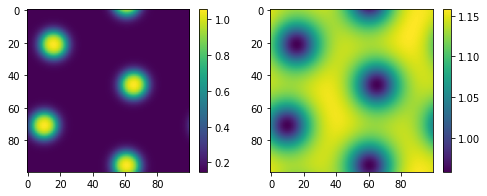

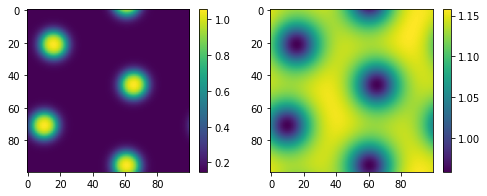

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [10]:
simulation.Ds

(0.01, 1.0)

In [11]:
data.shape

(2, 100, 100, 2)

In [12]:
dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
c_t = np.array([[(data[c, ..., t+1] if t+1 < data.shape[3] else post_data[c, ..., 0]) -  data[c, ..., t]
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [13]:
c_t.shape

(2, 100, 100, 2)

In [14]:
c_yy.shape

(2, 100, 100, 2)

In [15]:
T

2

In [16]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[dxdy  *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [17]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
indices_sub = indices_all[:, 30:65, 50:85]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
                         #dataset['obs_output'][second_s]])

diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
                         #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])

obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
#pde_X = obs_inputs#dataset['pde']
der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
#der_X_1 = np.concatenate([obs_inputs, der_u_outputs[:,0:1]], axis=1)
#pde_X = pde_X[:,:2]
#obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
#obs_test = np.concatenate([obs_inputs, der_u_xx_outputs], axis=1)

#pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [18]:
der_X.shape

(2450, 9)

In [19]:
c_xx.shape

(2, 100, 100, 2)

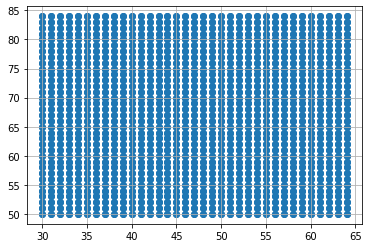

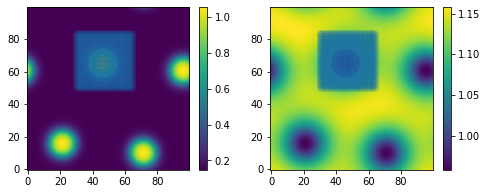

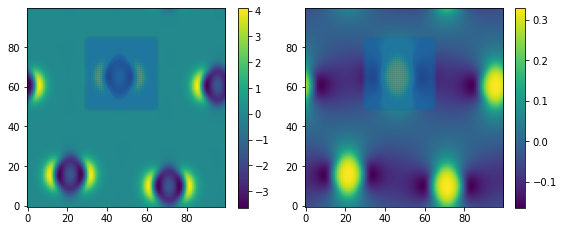

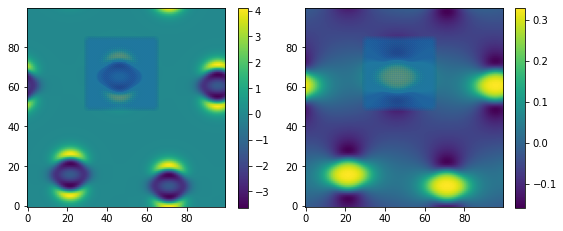

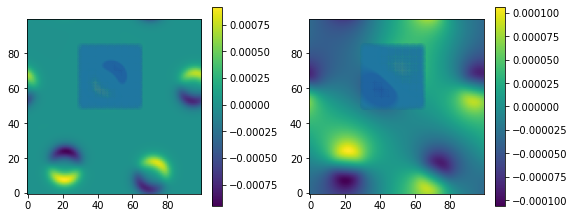

In [20]:
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (x_size-1)*obs_X[:,1]/simulation.L[1])
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.tight_layout()
plt.show()

In [21]:
der_X.shape

(2450, 9)

In [22]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)
# ds_obs = TINN_Dataset(tf.float32, obs_X)
# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)


#ds = TINN_Dataset(tf.float32, obs_X, der_X)
ds = TINN_Dataset(tf.float32, der_X)

In [23]:
ds.sizes

array([2450])

In [24]:
class Derivatives_list_Loss(tu.Loss):
    def __init__(self, dtype, l_d = [True, False, False, False, False, False], 
                 regularise=True, input_dim: int = 3, print_precision=".5f", **kwargs):
        super().__init__(
            name="Derivatives_Loss",
            regularise=regularise,
            residual_ret_num=1,
            residual_ret_names=tuple(np.array(["u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"])[l_d]),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim
        self.l_d = l_d

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        (_, _, u_t, u_xx, u_yy, _, v_t, v_xx, v_yy) = self.derivatives(pinn, inputs)
        ders = (u_xx, u_yy, u_t, v_xx, v_yy, v_t)
        ret = ()
        for index, is_true in enumerate(self.l_d):
            if is_true:
                ret += (ders[index] - x[:, self.input_dim+index : self.input_dim+index + 1],)
        return ret    

In [46]:
#layers = [3, 1024, 1024, 1024, 2]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 32, 32, 32, 32, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
                   regularise=True,
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
obs_loss = Observation_Loss(regularise=True, layers=layers)
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
der_loss = Derivatives_list_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
                            l_d = [False, True, False, False, False, False],
                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [ der_loss],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=1e-1),
                  alpha = 0.2, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [47]:
2450/49

50.0

In [48]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 245,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-3,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 22.128379665315, total regularised loss: 22.128379821777
Derivatives_Loss -> 
(1)  u_yy: 2.212838014937 
(1) lambdas : 1.000000000000 
Time taken: 6.16s

Start of epoch 100
total loss: 21.022629301995, total regularised loss: 21.022628784180
Derivatives_Loss -> 
(1)  u_yy: 2.102262954693 
(1) lambdas : 1.000000000000 
Time taken: 10.87s

Start of epoch 200
total loss: 21.023651842959, total regularised loss: 21.023653030396
Derivatives_Loss -> 
(1)  u_yy: 2.102365280152 
(1) lambdas : 1.000000000000 
Time taken: 9.61s

Start of epoch 300
total loss: 21.023762752302, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376323543 
(1) lambdas : 1.000000000000 
Time taken: 9.26s

Start of epoch 400
total loss: 21.023763230070, total regularised loss: 21.023765563965
Derivatives_Loss -> 
(1)  u_yy: 2.102376383264 
(1) lambdas : 1.000000000000 
Time taken: 9.22s

Start of epoch 500
total loss: 21.023763230070, total regularised loss: 21.

In [49]:
results_KM2 = modelKM.train(epochs = 5000+1,
                          batch_size = 245,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-3,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 0.38s

Start of epoch 100
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.18s

Start of epoch 200
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.51s

Start of epoch 300
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.17s

Start of epoch 400
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.18s

Start of epoch 500
total loss: 21.023762745783, total regularised loss: 21.0


Start of epoch 4500
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.39s

Start of epoch 4600
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 10.08s

Start of epoch 4700
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.31s

Start of epoch 4800
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.38s

Start of epoch 4900
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.52s

Start of epoch 5000
total loss: 21.023762745783, total regularised l

In [50]:
results_KM3 = modelKM.train(epochs = 5000+1,
                          batch_size = 245,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-3,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 0.32s

Start of epoch 100
total loss: 21.023762745783, total regularised loss: 21.023765563965
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000119209 
Time taken: 9.67s

Start of epoch 200
total loss: 21.023762745783, total regularised loss: 21.023765563965
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.61s

Start of epoch 300
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 10.01s

Start of epoch 400
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000119209 
Time taken: 9.90s

Start of epoch 500
total loss: 21.023762745783, total regularised loss: 21.


Start of epoch 4500
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.72s

Start of epoch 4600
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.19s

Start of epoch 4700
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.87s

Start of epoch 4800
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 10.11s

Start of epoch 4900
total loss: 21.023762745783, total regularised loss: 21.023763656616
Derivatives_Loss -> 
(1)  u_yy: 2.102376322728 
(1) lambdas : 1.000000000000 
Time taken: 9.54s

Start of epoch 5000
total loss: 21.023762745783, total regularised l

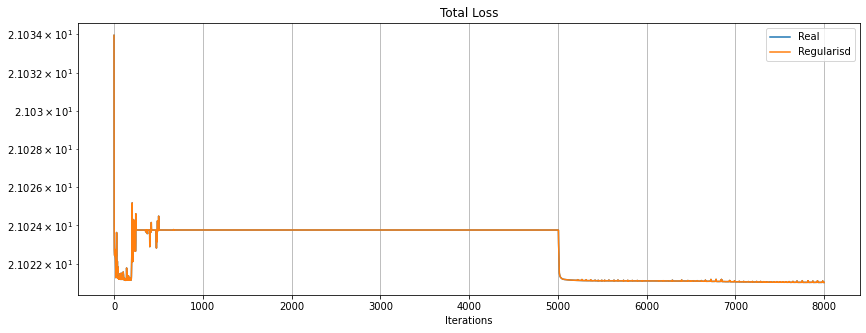

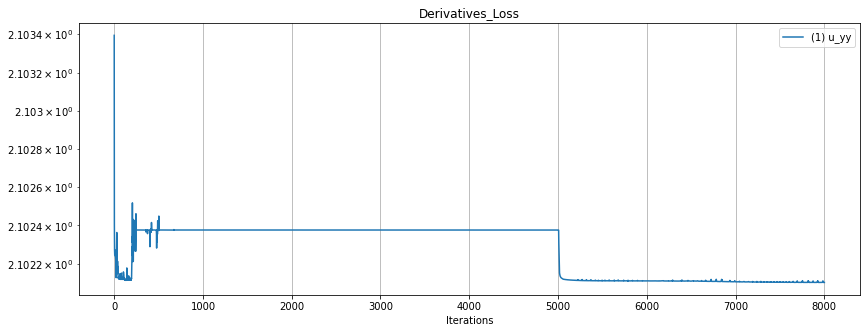

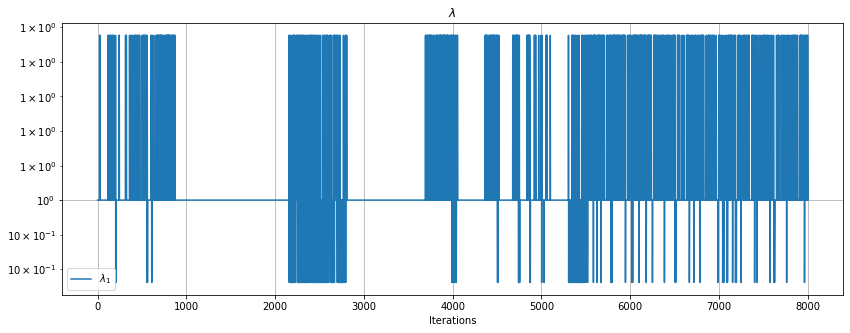

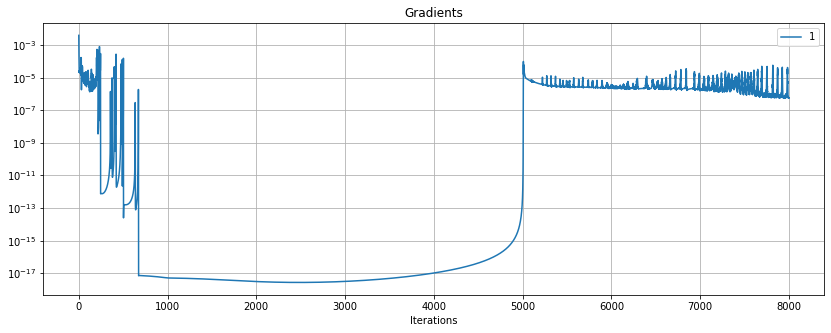

In [37]:
plot_result(merge_dict(results_KM, results_KM2, results_KM3), modelKM, start=0)

In [ ]:
'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
'rho_v': 1.5, 'kappa_u': 1.0

In [37]:
print(pde_resKM.trainables_str())

sigma_u: 0.16210 sigma_v: 0.07117 rho_u: 1.00643 rho_v: 1.18084 



In [38]:
def norm_params(pde_resKM, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = (pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u).numpy()
    sigma_v = (pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v).numpy()
    mu_u = (pde_resKM.mu_u.get_value(test_d)).numpy()
    rho_u = (pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v).numpy()
    rho_v = (pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    kappa_u = (pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + (sigma_v-sigma_v2)**2 +(mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + (rho_v-rho_v2)**2 +(kappa_u-kappa_u2)**2
           )
    
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

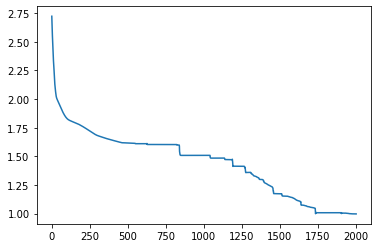

In [39]:
plt.plot(norm_params2(merge_dict(results_KM, results_KM2)#, results_KM3, results_KM4) 
                      ,simulation))

# Second test: No fixed parameter but more data for training

In [26]:
print(pde_resKM.trainables_str())

sigma_u: 0.38628 sigma_v: 0.46425 rho_u: 0.72278 rho_v: 1.29516 



In [ ]:
'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
'rho_v': 1.5, 'kappa_u': 1.0

In [39]:
@tf.function
def derivatives(pinn, x):
    #return pde_resKM.derivatives(pinn, x)
    return der_loss.derivatives(pinn, x)

In [40]:
test_d = obs_X[:,:3].astype(np.float32)

In [41]:
y, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_d)
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d) #/ pde_resKM.alpha_u
sigma_v = pde_resKM.sigma_v.get_value(test_d) #/ pde_resKM.alpha_v
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d) ##* pde_resKM.alpha_u * pde_resKM.alpha_v
rho_v = pde_resKM.rho_v.get_value(test_d) #* pde_resKM.alpha_u * pde_resKM.alpha_u
kappa_u = pde_resKM.kappa_u.get_value(test_d) #* pde_resKM.alpha_u * pde_resKM.alpha_u
#A = kappa_u = pde_resKM.A.get_value(test_d) 
#B = kappa_u = pde_resKM.B.get_value(test_d) 

In [42]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())

[0.15578279, 0.0003912134]
[0.1557828  0.00039121]


In [43]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = x_size * y_size/ L**2
#diffusion_u_space = D_u * dxdy * diffusion([x_size, y_size], u.numpy().reshape(x_size, y_size))
#diffusion_v_space = D_v * dxdy * diffusion([x_size, y_size], v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v


f_real = u * u * v / (1.0 + simulation.parameters["kappa_u"] * u * u)
f_u_real = - simulation.parameters["rho_u"] * f_real + simulation.parameters["mu_u"] * u - simulation.parameters["sigma_u"]
f_v_real = simulation.parameters["rho_v"] * f_real - simulation.parameters["sigma_v"]

d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v

def as_patch(m):
    if isinstance(m, np.ndarray):
        return m[block_size:].reshape(block_x, block_y).T
    else:
        return m.numpy()[block_size:].reshape(block_x, block_y).T

u = as_patch(u)
v = as_patch(v)
u_xx = as_patch(u_xx)
v_xx = as_patch(v_xx)
u_yy = as_patch(u_yy)
v_yy = as_patch(v_yy)
u_t = as_patch(u_t)
v_t = as_patch(v_t)
diff_u = as_patch(diffusion_u)
diff_v = as_patch(diffusion_v)

u_obs = as_patch(obs_X[:,3])
v_obs = as_patch(obs_X[:,4])
u_xx_obs = as_patch(der_u_outputs[:,0])
u_yy_obs = as_patch(der_u_outputs[:,1])
u_t_obs = as_patch(der_u_outputs[:,2])
v_xx_obs = as_patch(der_v_outputs[:,0])
v_yy_obs = as_patch(der_v_outputs[:,1])
v_t_obs = as_patch(der_v_outputs[:,2])
diff_u_obs = as_patch(diff_outputs[:,0])
diff_v_obs = as_patch(diff_outputs[:,1])

#diff_Y = np.array([[dxdy * [0.005, 0.2][c] *diffusion((x_size,y_size), data[c, ..., t]) 
#                    for t in range(data.shape[3])]
#                    for c in range(data.shape[0])
#                   ])
#diff_Y = np.einsum("ctij -> cijt", diff_Y)
#u2v = u * u * v

#non_lin_u = -u2v
#non_lin_v = u2v
#f_u = - A + (B + 1) * u - u2v
#f_v = - B * u + u2v
#d_t_u = - D_u * (u_xx + u_yy) + f_u
#d_t_v = - D_v * (v_xx + v_yy) + f_v

In [44]:
block_size

1225

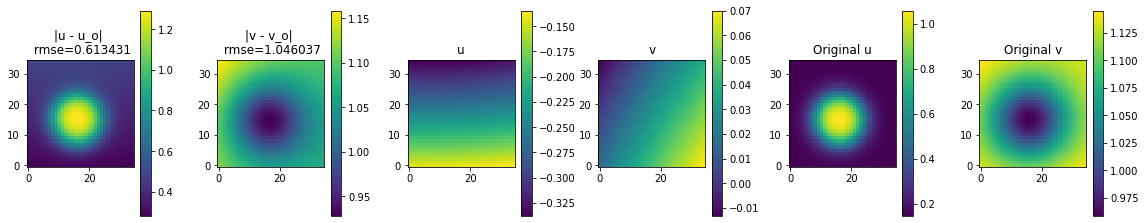

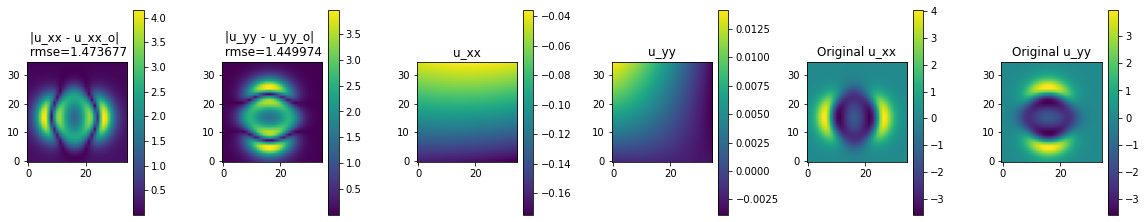

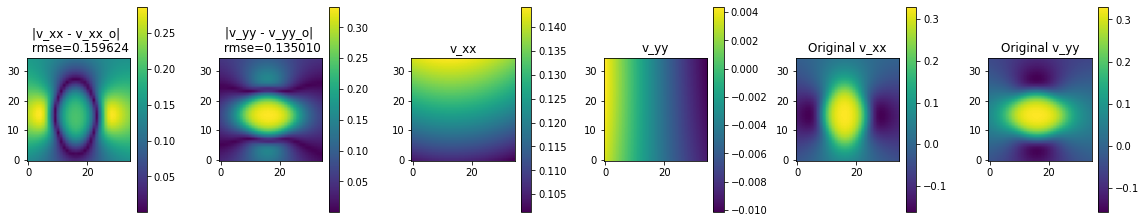

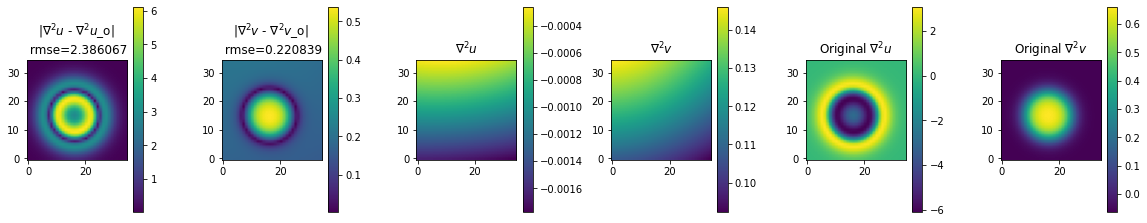

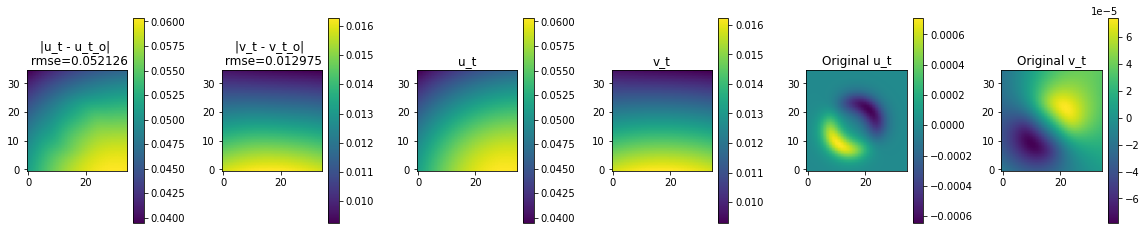

In [45]:
def p(m1, m2, m3, m4, t1="u", t2="v"):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(161)
    rmse = np.sqrt(np.mean((m1 - m3)**2))
    plt.title(f"|{t1} - {t1}_o| \n rmse={rmse:.6f}")
    plt.imshow((np.abs(m1 - m3)), origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(162)
    rmse = np.sqrt(np.mean((m2 - m4)**2))
    plt.title(f"|{t2} - {t2}_o| \n rmse={rmse:.6f}")
    plt.imshow((np.abs(m2 - m4)), origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(163)
    plt.title(f"{t1}")
    plt.imshow(m1, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(164)
    plt.title(f"{t2}")
    plt.imshow(m2, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(165)
    plt.title(f"Original {t1}")
    plt.imshow(m3, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(166)
    plt.title(f"Original {t2}")
    plt.imshow(m4, origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()



p(u, v, u_obs, v_obs)
p(u_xx, u_yy, u_xx_obs, u_yy_obs,"u_xx", "u_yy")
p(v_xx, v_yy, v_xx_obs, v_yy_obs,"v_xx", "v_yy")
p(diff_u, diff_v, diff_u_obs, diff_v_obs,r"$\nabla^2 u$", r"$\nabla^2 v$")
p(u_t, v_t, u_t_obs, v_t_obs,"u_t", "v_t")


In [32]:
from scipy.optimize import lsq_linear